# Bayesian PI.

## Introduction


While I usually prefer the Day/Month/Year calendar format, I have to admit that the Month/Day/Year format offers something unique: it gives us 3/14, [officially recognized as $\pi$ day by the United States](https://en.wikisource.org/wiki/H._RES._224_Supporting_the_designation_of_Pi_Day,_and_for_other_purposes) and [Belize](https://www.scientificamerican.com/blog/observations/american-pi-why-the-day-belongs-to-the-u-s-and-belize/).

A common tutorial example in sampling/Monte Carlo methods is the estimation of $\pi$. 

These examples typically involve running many simulations, generating random points, and calculating how often they fall within a circle. It is then shown that, on average, the result approximates the real value of $\pi$. 

However, these approaches often stop at point estimation and, at best, showing that multiple independent simulations concentrate around the real $\pi$  rather than providing a formal quantification of uncertainty. Naturally, this brings us to the question of uncertainty quantification, how confident are we in our estimate of  at any given point? This what Bayesian statistics  can tell you.

This is where **Bayesian statistics** comes in. Instead of treating our estimate as a single number, Bayesian inference allows us to compute a probability distribution over possible values of $\pi$. **This approach lets us quantify how confident we are of our estimate**

This post extends that approach by applying Bayesian reasoning to the estimation of $\pi$. [Just as I previously used Bayesian inference to assess bias in coin flips](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/), here we will construct confidence intervals for  that update dynamically as more data becomes available, providing a structured way to quantify uncertainty in our estimates.



Before starting, let us import relevant libraries and set a reproducible seed. In order to celebrate $\pi$ day, the ideal seed would be $\pi$ itself.
Unfortunately in `numpy` seeds need to be integers. Let us settle with a number written from all $\pi$ digits that I can remember off the top of my head.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(314159)

# Sampling $\pi$
We sample random points uniformly inside a square and check whether they fall inside a circle of radius 1.

In [2]:
x = np.random.uniform(-1,1,10000)
y = np.random.uniform(-1,1,10000)
rho = np.sqrt(x**2+y**2)
success = rho<1

Here, `success` is a boolean array where True indicates that a sampled point falls inside the circle.  

The reasoning is that  area of the unit circle (radius = 1) is $\pi$, while the area of the square $[−1,1]×[−1,1]$ is 4. Thus, the probability of a uniformly sampled point falling inside the circle is ratio of these areas, i.e., $\pi/4$. 


$$\frac{\pi}{4} \approx \frac{\text{\textcolor{green}{Points Inside Circle}}}{\text{Total Points}}$$

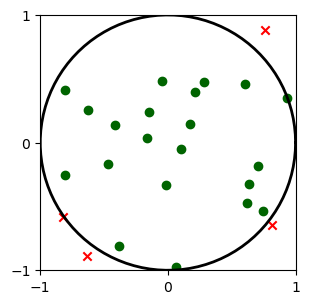

In [3]:
def plot_square(ax,N):

    ax.scatter(x[:N][success[:N]], y[:N][success[:N]], color='darkgreen', label="Success")
    ax.scatter(x[:N][~success[:N]], y[:N][~success[:N]], color='red', marker='x', label="Failure")

    # Force square aspect ratio
    ax.set_aspect('equal')

    # Set tight boundaries for ax[0]
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    # Set ticks only at {0, 0.5, 1}
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])

    theta = np.linspace(0, 2*np.pi, 100)  # Angles from 0 to π
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=2, label="Circle")    


fig, ax = plt.subplots(1, 1, figsize=(3.2, 3.5))

plot_square(ax, 25)

plt.tight_layout()
plt.savefig('circle',dpi=600)
plt.show()

Let us test this. That would mean that the `mean` of `sucess` would be approximately $\pi$. In `numpy`, True is treated as 1, and False is treated as 0 in numerical operations. This means that when we take the mean of the success array, we are  computing the fraction of points where `sucess` is True, or the fraction of points that landed inside the circle:

In [4]:
4*success.mean()

3.1332

At first glance, this seems promising: the estimate lands reasonably close to $\pi$, correct to one decimal place. But how much should we trust this number? What if we ran this experiment again? Would we get the same result?

## Beyond Point Estimates: Bayes

Estimating $\pi$ by sampling random numubers naturally involves randomness. Each run of our simulation produces a slightly different estimate. If we increase the number of samples, our estimates tend to cluster around the true value of $\pi$ but by how much? And how do we express this uncertainty mathematically?

This is where Bayesian inference comes in. Instead of treating our estimate as a single number, we seek to determine a probability distribution over possible values of π. This approach allows us to:
- Quantify uncertainty -- how confident are we in our estimate?
- Update our belief dynamically -- as more data becomes available, our estimate of π should become more refined.

### Likelihood

Each sampled point either falls inside the circle (success, 1) or outside (failure, 0). If we assume each sample is independent, the number of successes $s$ out of $N$ trials follows a Binomial distribution

$$p(s|q,N) = \binom{N}{s}  q^s (1 - q)^{N - s} $$

### Posterior

Now that we have our likelihood function, we can apply Bayes’ theorem to update our belief about qq after observing data. The logic follows the same done for our [previous blog on the subject](https://labpresse.com/why-do-we-need-bayesian-statistics-part-i-asserting-if-a-coin-is-biased-tutorial/)
$$ p(q|s,N) = p(q) \frac{p(s|q,N)}{p(s|N)} \propto p(q) {p(s|q,N)}$$

Since we work in a limited interval ($q$ represents $\pi/4$ and is between 0 and 1) we started with a uniform prior, meaning $p(q) = 1$ for all $q$. Thus the posterior simplifies to
$$ p(q∣s,N) = C q^s (1 - q)^{N - s}$$
where $C$ is a normalization constant ensuring the total probability sums to 1.

In [5]:
def likelihood(sucess,q):
    return q**(sucess.sum())* (1-q)**((1-sucess).sum())

def posterior(data,precision=1000000):
    q = np.linspace(0,1,precision)
    dq = q[1]-q[0]
    
    #non-marginalized posterior, we comment the prior calculation as we are using a uniform one.
    nm_posterior = likelihood(data,q) #*prior(q)

    #denominator integral for marginalization
    integral = np.sum(nm_posterior)*dq

    posterior = nm_posterior/integral
    return q, posterior




### Transforming the Posterior into $\pi$

Since $$\pi =4q$$

we can transform samples from $q$'s posterior to a posterior for $\pi$
$$p(\pi|s,N) = \frac{1}{4}p(q|s,N)$$

To visualize how Bayesian inference improves our estimate of qq, let’s plot its posterior distribution after 10, 100, and 1000 samples



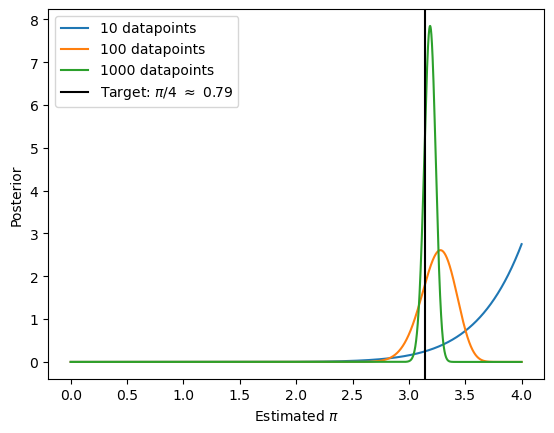

In [6]:
for j in [10,100,1000]:
    q, p = posterior(success[:j])
    plt.plot(4*q,p/4,label='{} datapoints'.format(j))
plt.axvline(np.pi,color = 'k',label=r'Target: $\pi$/4 $\approx$ {:.2f}'.format(np.pi/4))
plt.xlabel(r'Estimated $\pi$')
plt.ylabel('Posterior')
plt.legend()
plt.savefig('pi_post')

Interestingly, in our first batch of 10 samples, all points happened to fall inside the circle. This is possible when dealing with randomness. This highlights why uncertainty quantification is essential: if we only relied on a point estimate, we might wrongly assume $\pi = 4$. 

This is the power of Bayesian inference: as data accumulates, our uncertainty decreases, and the posterior indeed concentrates around the true value of $\pi$.


In [7]:
def credible_interval(q, post, conf=0.95, init_dif=1):
    dq = q[1] - q[0]
    max_ind = post.argmax()
    dif = init_dif  # Start with an initial guess for dif
    
    # Compute the initial sum
    interval_sum = np.sum(post[max(0, max_ind - dif):min(len(post), max_ind + dif + 1)]) * dq
    
    while True:
        left_ind = max(0, max_ind - dif - 1)
        right_ind = min(len(post) - 1, max_ind + dif + 1)
        
        if interval_sum >= conf:
            # Try reducing from one side
            if dif > 0:
                interval_sum -= post[left_ind + 1] * dq if max_ind - dif >= 0 else 0
                interval_sum -= post[right_ind - 1] * dq if max_ind + dif < len(post) else 0
                if interval_sum < conf:
                    break
                dif -= 1
        else:
            # Expand the interval
            dif += 1
            interval_sum += post[left_ind] * dq if max_ind - dif >= 0 else 0
            interval_sum += post[right_ind] * dq if max_ind + dif < len(post) else 0
    #print(interval_sum)
            
    return q[max(0, max_ind - dif)], q[min(len(post) - 1, max_ind + dif)]

## Visualizing the Bayesian update

To further illustrate this, let’s look at an animation that dynamically shows how our estimate of $\pi$ evolves as more data is collected. (Full code on my [GitHub](https://github.com/PessoaP/blog/blob/master/Coins/PI.ipynb))




In [8]:
#Removed data block, see notebook on GitHub for full code
import imageio
import matplotlib.ticker as ticker

Ns = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,150,200,250,300,350,400,500,600,700,800,900,1000]
frames=[]

initial_dif = 1000000
for i in range(len(Ns)):
    N = Ns[i]
    fig,ax =plt.subplots(1,2,figsize =(7,3.5))

    
    q,post= posterior(success[:N])
    ax[1].plot(4*q,post/4)
    fig.suptitle(f'{N:>5} datapoints', y=0.96) 

    
    ax[1].axvline(np.pi,color = 'k',label=r'Real $\pi$')
    ax[1].set_xlabel(r'Estimated $\pi$',fontsize=15)
    ax[1].set_ylabel('Posterior',fontsize=15)
    ax[1].set_xlim(0, 4)

    #print(initial_dif)
    conf95 = credible_interval(q,post,init_dif=initial_dif)
    initial_dif = int(((conf95[1]-conf95[0])/(q[1]-q[0]))//2)
    
    ax[1].fill_between(4*np.array(conf95),(0,0),(post.max()/np.pi,post.max()/np.pi),
                       color='r',alpha=.25,label='95% credibility')
    ax[1].set_yticks([])

    ax[1].legend(loc=2)

    plot_square(ax[0],N)
    ax[0].set_xlabel('Samples',fontsize=15)
    

    #plt.show()

    filename = f'gif_frames/frame_{i}.png'
    plt.tight_layout()
    plt.savefig(filename)
    frames.append(filename)

    plt.close()


output_gif = 'animation.gif'
imageio.mimsave(output_gif, [imageio.imread(frame) for frame in frames], duration=.9)


/tmp/ipykernel_148093/3814921628.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(output_gif, [imageio.imread(frame) for frame in frames], duration=.9)


**Left Panel:** The sampled points appear within the circle. We mark in green when fall inside the circle (successes), while red points fall outside (failures).The fraction of points inside the circle is computed at each step.

**Right Panel:** Posterior distribution for π updated in real-time, with the 95% credible interval shown as a red shaded region. (A 95% credible interval means there's a 95% probability, given our data, that $\pi$ lies within that shaded area.)

Initially, with only a small number of samples, this interval is broad and skewed towards larger values. However, as more points are collected, the posterior distribution narrows and concentrates tightly around the true value of $\pi$.

This visualization highlights the strength of Bayesian methods in quantifying uncertainty, allowing our confidence in the estimate to grow as more data is collected.

## Happy $\pi$ day